In [65]:
import numpy as np
import astropy.constants as aconst
import scipy.constants as const
from scipy.interpolate import interp1d
from scipy import integrate
from pycbc.types import TimeSeries
from pycbc.waveform import taper_timeseries
from pycbc.psd import aLIGOZeroDetHighPower
from pesummary.gw.conversions.mass import component_masses_from_mtotal_q
from simple_pe.waveforms import (
    orthonormalize_modes, calculate_mode_snr, two_ecc_harms_snr, mode_array
)
from pesummary.gw.conversions.mass import m_total_from_m1_m2, q_from_m1_m2


def apply_tlen(h, tlen):
    """
    Resize waveform to specified length.

    :param h: waveform
    :type h: TimeSeries object, required
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, required

    :return h: resized waveform
    :rtype h: TimeSeries object
    """
    if tlen is not None:
        s_rate = int(1/h.delta_t)
        if tlen*s_rate > len(h):
            h.resize(tlen*s_rate)
        else:
            h = h[len(h)-tlen*s_rate:]
    return h


def generate_eccentric_waveform(
    m_total, q, e, chi1, chi2, f_gen, s_rate, phase=0, inclination=0,
    distance=1, f_ref_e=None, tlen=None, taper=True, to_fs=True,
    mode_array=[[2, 2]], align_merger=False, use_22_merger_time=True
):
    """
    Calculates eccentric teobresums waveform for the specified parameters.

    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi1: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param phase: coalescence phase
    :type phase: float, optional
    :param inclination: inclination of orbital plane
    :type inclination: float, optional
    :param distance: distance
    :type distance: float, optional
    :param f_ref_e: frequency at which eccentricity is defined (default f_gen)
    :type f_ref_e: float, optional
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, optional
    :param taper: flag to taper waveform
    :type taper: boolean, optional
    :param to_fs: flag to return waveform in frequency domain
    :type to_fs: boolean, optional
    :param mode_array: list of modes to include in waveform
    :type mode_array: list of lists of integer pairs, optional
    :param align_merger: whether to align merger to end of waveform
    :type align_merger: boolean, optional
    :param use_22_merger_time: whether to calculate merger time from 22 mode,
                               if 22 not included only works for single mode
    :type use_22_merger_time: boolean, optional

    :return h_plus: plus polarisations of waveform
    :rtype h_plus: TimeSeries or FrequencySeries object
    :return h_cross: cross polarisations of waveform
    :rtype h_cross: TimeSeries or FrequencySeries object
    """

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]
    if use_22_merger_time and 1 not in mode_lm:
        if len(mode_lm) == 1:
            mode_lm_gen = [1] + mode_lm
        else:
            mode_lm_gen = mode_lm
            use_22_merger_time = False
    else:
        mode_lm_gen = mode_lm

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': m_total,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm_gen,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination,
    }
    t, hp, hc, hlm, _ = EOBRun_module.EOBRunPy(pars)

    # Calculate merger time
    if use_22_merger_time:
        tmrg = t[np.argmax(hlm['1'][0])]
        if 1 not in mode_lm:
            hp = hlm[str(mode_lm[0])][0]*np.cos(hlm[str(mode_lm[0])][1])
            hc = hlm[str(mode_lm[0])][0]*np.sin(hlm[str(mode_lm[0])][1])
    else:
        tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    hp = apply_tlen(hp, tlen)
    hc = apply_tlen(hc, tlen)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if align_merger:
        hp = hp.cyclic_time_shift(hp.sample_times[-1])
        hc = hc.cyclic_time_shift(hc.sample_times[-1])
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc


def teobresums_dali_wrapper(fd=False, **args):
    """Wrapper to put TEOBResumS-Dali waveform into pycbc

    Parameters
    ----------
    fd: boolean
        whether to return waveform in frequency domain
    **args: dict
        dictionary of waveform parameters
    """

    m_total = m_total_from_m1_m2(args['mass1'], args['mass2'])
    q = 1/q_from_m1_m2(args['mass1'], args['mass2'])
    assert args['spin1x'] == 0.0 and args['spin1y'] == 0.0
    assert args['spin2x'] == 0.0 and args['spin2y'] == 0.0
    if 'ecc10' not in args.keys():
        if 'ecc10sqrd' in args.keys():
            if args["ecc10sqrd"] < 0 and np.isclose(
                args["ecc10sqrd"], 0, rtol=0, atol=2e-15
                    ):
                args["ecc10sqrd"] = 0
            args["ecc10"] = np.sqrt(args["ecc10sqrd"])
        else:
            args["ecc10"] = 0
    if args['delta_f'] is None:
        tlen = None
    else:
        tlen = int(1/args['delta_f'])
    if args['delta_t'] is None:
        args['delta_t'] = 1/(2*args['f_final'])
    if args['mode_array'] is None:
        args['mode_array'] = [[2, 2], [2, 1], [3, 3], [3, 2], [4, 4]]
    if 'use_22_merger_time' not in args.keys():
        args['use_22_merger_time'] = True

    hp, hc = generate_eccentric_waveform(
        m_total, q, args['ecc10'], args['spin1z'], args['spin2z'],
        args['f_lower'], int(1/args['delta_t']), phase=args['coa_phase'],
        inclination=args['inclination'], distance=args['distance'], f_ref_e=10,
        tlen=tlen, taper=False, to_fs=fd, mode_array=args['mode_array'],
        align_merger=fd, use_22_merger_time=args['use_22_merger_time']
    )
    return hp, hc


def calc_f_gen(f_low, n_ecc_harms):
    """
    Calculates frequency to generate waveform at to ensure all requested
    harmonics are included at f_low.

    :param f_low: initial frequency
    :type f_low: float, required
    :param n_ecc_harms: number of harmonics to include at initial frequency
    :type n_ecc_harms: integer, required

    :return f_gen: waveform generation frequency
    :rtype f_gen: float
    """

    if n_ecc_harms == 1:
        f_gen = f_low - 3
    elif n_ecc_harms == 2:
        f_gen = f_low*(2/3)
    else:
        f_gen = f_low*(2/n_ecc_harms)
    return f_gen


def shifted_f(f, e, m_total, q):
    """
    Calculates how to shift frequency such that anomaly changes by 2pi.

    :param f: Original starting frequency
    :type f: float, required
    :param e: Eccentricity
    :type e: float, required
    :param m_total: Total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required

    :return s_f: Shifted starting frequency
    :rtype s_f: float
    """

    # Parameter conversions
    m_total_kg = m_total*aconst.M_sun.value
    p = 2/f
    a = ((const.G*m_total_kg*p**2)/(4*np.pi**2))**(1/3)

    # Calculate change in frequency per azimuthal orbit
    m1, m2 = component_masses_from_mtotal_q(m_total_kg, 1/q)
    numerator1 = (2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2
                  * (1 + (73/24)*e**2 + (37/96)*e**4))
    denominator1 = 5*const.c**5*p**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    delta_f_orbit = numerator1/denominator1

    # Calculate apsidal advance per azimuthal orbit
    numerator2 = 6*np.pi*const.G*m_total_kg
    denominator2 = const.c**2*a*(1-e**2)
    delta_phi = numerator2/denominator2

    # Calculate number of azimuthal orbits corresponding to radial orbit
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)

    s_f = f - delta_f_orbit*n_orbit
    return s_f


def shifted_e(s_f, f, e):
    """
    Calculates how to shift eccentricity to match a shifted frequency.

    :param s_f: Shifted starting frequency
    :type s_f: float, required
    :param f: Original starting frequency
    :type f: float, required
    :param e: Original starting eccentricity
    :type e: float, required

    :return s_e: Shifted starting eccentricity
    :rtype s_e: float
    """

    # Handle non-eccentric case
    if e == 0:
        return np.zeros_like(s_f)
    elif e == 1:
        return np.ones_like(s_f)

    # Calculate constant of proportionality
    constant = f*e**(18/19)*(1+(121/304)*e**2)**(1305/2299)*(1-e**2)**(-3/2)

    # Create interpolation function and interpolate
    e_interps = np.linspace(0, 1, 10**6)[1:]
    e_term_1 = e_interps**(-18/19)
    e_term_2 = (1+(121/304)*e_interps**2)**(-1305/2299)
    e_term_3 = (1-e_interps**2)**(3/2)
    f_interps = constant*e_term_1*e_term_2*e_term_3
    f_interps = np.insert(f_interps, 0, np.inf)
    e_interps = np.insert(e_interps, 0, 0)
    ef_interp_fn = interp1d(f_interps, e_interps)

    try:
        s_e = ef_interp_fn(s_f)
    except ValueError:
        raise ValueError(f'shifted_e interp failed with s_f={s_f}, '
                         + f'f={f}, e={e}')

    return s_e


def calc_delta_phi(t_points, f_points, f_gen, e, m_total, q):
    '''
    Calculates change in phase by integrating evolution equations.

    :param t_points: Time points to integrate over
    :type t_points: List or array, required
    :param f_points: Frequency points to integrate over
    :type f_points: List or array, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param e: eccentricity
    :type e: float, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required

    :return delta_phi: change in phase
    :rtype delta_phi: float
    '''

    # Setup parameters
    ft_interp = interp1d(t_points, f_points, kind='linear')
    ts = np.linspace(*t_points, 10**6)
    fs = ft_interp(ts)
    es = shifted_e(fs, f_gen, e)
    P_0 = 2/f_points[0]

    # Calculate dP/dt
    prefactor = -192*np.pi/(5*const.c**5)
    P_term = (np.pi*const.G*fs)**(5/3)
    m1, m2 = component_masses_from_mtotal_q(m_total, q)
    m1 *= aconst.M_sun.value
    m2 *= aconst.M_sun.value
    m_term = m1*m2/(m1+m2)**(1/3)
    e_term = (1+(73/24)*es**2+(37/96)*es**4)/(1-es**2)**(7/2)
    dP_dts = prefactor*P_term*m_term*e_term

    # Integrate to get delta phi
    cum_P = integrate.cumulative_trapezoid(dP_dts, ts, initial=0)
    delta_phi = -4*np.pi*integrate.trapezoid(1/(cum_P+P_0), ts)

    return delta_phi


def compute_s_factor(h, s):
    '''
    Computes correction factor to shift a waveform back by 2pi in mean anomaly

    :param h: Unshifted waveform
    :type h: TimeSeries object, required
    :param s: Shifted waveform
    :type s: TimeSeries object, required

    :return s_factor: correction factor
    :rtype s_factor: float
    '''

    h_peaks_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
    s_peaks_inds = np.diff(np.sign(np.diff(np.abs(s)))) < 0
    h_peaks = h.sample_times[1:-1][h_peaks_inds]
    s_peaks = s.sample_times[1:-1][s_peaks_inds]
    s_factor = 1
    if len(h_peaks) >= 2 and len(s_peaks) >= 2:
        s_denom = (1+(h_peaks[0]-s_peaks[1])/(h_peaks[1]-h_peaks[0]))
        if s_denom != 0:
            s_factor = 1/s_denom

    return s_factor


def compute_s_phi_factor(s, s_f_val, f_gen, e, m_total, q):

    '''
    Calculates correction factor to evolve phase back 2pi in mean anomaly.

    :param s: Shifted waveform
    :type s: TimeSeries object, required
    :param s_f_val: waveform generation frequency of shifted waveform
    :type s_f_val: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param e: eccentricity
    :type e: float, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required

    :return s_phi_factor: correction factor
    :rtype s_phi_factor: float
    '''

    # Calculate time of first trough
    s_troughs = np.diff(np.sign(np.diff(np.abs(s)))) > 0
    s_first_trough = s.sample_times[1:-1][s_troughs][0]
    dt = (s.sample_times[1]-s.sample_times[0])
    s_trough_ind = int((s_first_trough-s.sample_times[0])/dt)

    # Calculate frequency at first trough
    omega_i_start = (np.angle(s[1])-np.angle(s[0]))/dt
    f_i_start = np.abs(omega_i_start/(2*np.pi))
    omega_i_trough = (np.angle(s[s_trough_ind+1])-np.angle(s[s_trough_ind]))/dt
    f_i_trough = np.abs(omega_i_trough/(2*np.pi))
    f_trough = s_f_val*(f_i_trough/f_i_start)

    # Evolve over first cycle
    delta_phi = calc_delta_phi([s_first_trough, s.sample_times[0]],
                               [f_trough, s_f_val],
                               f_gen, e, m_total, q)

    # Calculate s_phi_factor
    s_start_ang = np.angle(s[0])
    s_calc_ang = (np.angle(s[s_trough_ind])+delta_phi)
    ang_diff_norm = s_start_ang % (2*np.pi) - s_calc_ang % (2*np.pi)
    s_phi_factor = 1 + ang_diff_norm/s_calc_ang

    return s_phi_factor


def get_comp_shifts(
    h, m_total, q, e, chi1, chi2, f_gen, s_rate, n_ecc_gen
):
    '''
    Calculates shifted frequency and eccentricity required to create each
    component waveform (beyond first).

    :param h: First unshifted waveform
    :type h: TimeSeries object, required
    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, required

    :return s_f_vals: Shifted frequency for all components beyond first
    :rtype s_f_vals: array of floats
    :return s_e_vals: Shifted eccentricity for all components beyond first
    :rtype s_e_vals: array of floats
    :return s_phi_factor: phase correction factor
    :rtype s_phi_factor: float
    '''

    s_f = shifted_f(f_gen, e, m_total, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = generate_eccentric_waveform(
            m_total, q, s_e, chi1, chi2, s_f, s_rate,
            tlen=None, taper=False, to_fs=False, align_merger=False
        )
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out correction factors by examining peaks of both waveforms
        s_factor = compute_s_factor(h, s_wf)
        s_phi_factor = compute_s_phi_factor(s_wf, s_f, f_gen, e, m_total, q)

    else:
        s_factor = 1
        s_phi_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    return s_f_vals, s_e_vals, s_phi_factor


def gen_component_wfs(m_total, q, e, chi1, chi2, f_gen, s_rate, phase,
                      inclination, distance, tlen, n_ecc_gen,
                      align_merger=False, lms=['22'],
                      approximant='TEOBResumS-Dali'):
    '''
    Creates n_ecc_gen component waveforms used to make harmonics, all equally
    spaced in mean anomaly at a fixed time before merger.

    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_gen: waveform generation frequency
    :type f_gen: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param phase: coalescence phase
    :type phase: float, required
    :param inclination: inclination of orbital plane
    :type inclination: float, required
    :param distance: distance
    :type distance: float, required
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, required
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, required
    :param align_merger: whether to align merger to end of waveform
    :type align_merger: boolean, optional
    :param lms: higher multipoles to calculate dominant harmonic
    :type lms: list, optional
    :param approximant: the approximant generator to use
    :type approximant: str, optional

    :return comp_wfs: component waveforms to build harmonics
    :rtype comp_wfs: list of TimeSeries objects
    '''
    
    # Calculates first component waveform and shifts required for others
    comp_wfs = {}
    h_zero_phases = {}
    for lm in lms:
        hp, hc = generate_eccentric_waveform(
            m_total, q, e, chi1, chi2, f_gen, s_rate, phase=phase,
            inclination=inclination, distance=distance, tlen=None, taper=False,
            to_fs=False, align_merger=False,
            mode_array=mode_array(lm, approximant)
        )
        h = hp - 1j*hc
        h_zero_phases[lm] = np.angle(h[0])
        if lm == '22':
            s_f_vals, s_e_vals, s_phi_factor = get_comp_shifts(
                h, m_total, q, e, chi1, chi2, f_gen, s_rate, n_ecc_gen
            )

        # Apply tlen and taper first waveform
        hp = apply_tlen(h.real(), tlen)
        hc = apply_tlen(-h.imag(), tlen)
        h_taper_p = taper_timeseries(hp, tapermethod='start')
        h_taper_c = taper_timeseries(hc, tapermethod='start')
        h = h_taper_p - 1j*h_taper_c

        # Save first component waveform
        if lm == '22':
            h_ts = h.sample_times
            h_dt = h.delta_t
            comp_starts = [h.sample_times[0]]
        comp_wfs[lm] = [h]

    # Generate all component waveforms
    delta_phis = []
    for i in range(n_ecc_gen-1):

        for lm in lms:

            # Create waveform
            hp, hc = generate_eccentric_waveform(
                m_total, q, s_e_vals[i], chi1, chi2, s_f_vals[i], s_rate,
                phase=phase, inclination=inclination, distance=distance,
                tlen=tlen, taper=False, to_fs=False, align_merger=False,
                mode_array=mode_array(lm, approximant)
            )
            h = hp - 1j*hc
            h *= np.exp(1j*(h_zero_phases[lm]-np.angle(h[0])))
            if lm == '22':
                comp_starts.append(h.sample_times[0])
    
            # Trim waveform to same size as first (shortest) and resize
            wf_trim_interpolate = interp1d(h.sample_times, h,
                                           bounds_error=False,
                                           fill_value=0)
            wf_trim_strain = wf_trim_interpolate(h_ts)
            h = TimeSeries(wf_trim_strain, h_dt,
                           epoch=comp_starts[0])
    
            # Calculate and apply phase shift
            if lm == '22':
                delta_phis.append(calc_delta_phi(
                    [comp_starts[0], comp_starts[-1]], [f_gen, s_f_vals[i]],
                    f_gen, e, m_total, q
                ))
            lm_corr = int(lm[1])/2
            h_corr = h*np.exp(1j*delta_phis[i]*s_phi_factor*lm_corr)
    
            # Re-taper waveform after trimming
            h_taper_p = taper_timeseries(h_corr.real(), tapermethod='start')
            h_taper_c = taper_timeseries(-h_corr.imag(), tapermethod='start')
            h_corr = h_taper_p - 1j*h_taper_c
    
            comp_wfs[lm].append(h_corr)

    # Align mergers to end of waveform
    if align_merger:
        t_end = comp_wfs['22'][0].sample_times[-1]
        for lm in lms:
            for i in range(n_ecc_gen):
                hp = comp_wfs[lm][i].real().cyclic_time_shift(t_end)
                hc = -comp_wfs[lm][i].imag().cyclic_time_shift(t_end)
                comp_wfs[lm][i] = hp - 1j*hc

    for lm in lms:
        for i in range(len(comp_wfs[lm])):
            plt.plot(comp_wfs[lm][i].sample_times, comp_wfs[lm][i], c=f'C{i}')
            plt.plot(comp_wfs[lm][i].sample_times, np.abs(comp_wfs[lm][i]), c=f'C{i}', ls='dotted', alpha=0.5)
            plt.plot(comp_wfs[lm][i].sample_times, -np.abs(comp_wfs[lm][i]), c=f'C{i}', ls='dotted', alpha=0.5)
        plt.xlim(-14.5, -13.5)
        plt.ylim(-max(np.abs(comp_wfs[lm][i][:8096]))*1.5, max(np.abs(comp_wfs[lm][i][:8096]))*1.5)
        plt.title(lm)
        plt.show()

    return comp_wfs


def calculate_eccentric_harmonics(
    m_total, q, e, chi1, chi2, f_low, s_rate, phase=0, inclination=0,
    distance=1, f_ref_e=None, tlen=None, n_ecc_harms=1, n_ecc_gen=6, psd=None,
    orthonormalize=True, align_merger=False, lms=['22'],
    approximant='TEOBResumS-Dali'
):
    """
    Calculates eccentric harmonics for the specified parameters.

    :param m_total: total mass
    :type m_total: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param e: eccentricity
    :type e: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param f_low: initial frequency
    :type f_low: float, required
    :param s_rate: sample rate
    :type s_rate: float, required
    :param phase: coalescence phase
    :type phase: float, optional
    :param inclination: inclination of orbital plane
    :type inclination: float, optional
    :param distance: distance
    :type distance: float, optional
    :param f_ref_e: frequency at which eccentricity is defined (default f_low)
    :type f_ref_e: float, optional
    :param tlen: length in seconds to resize waveforms to
    :type tlen: float, optional
    :param n_ecc_harms: number of eccentric harmonics to generate
    :type n_ecc_harms: integer, optional
    :param n_ecc_gen: number of waveforms to use to generate harmonics
    :type n_ecc_gen: integer, optional
    :param psd: psd(s) to use to generate eccentric harmonics
    :type psd: FrequencySeries object or dict of FrequencySeries
               object, optional
    :param orthonormalize: whether to orthonormalize eccentric harmonics
    :type orthonormalize: boolean, optional
    :param align_merger: whether to align merger to end of waveform
    :type align_merger: boolean, optional
    :param lms: higher multipoles to calculate dominant harmonic
    :type lms: list, optional
    :param approximant: the approximant generator to use
    :type approximant: str, optional

    :return h_plus: plus polarisations of eccentric harmonics
    :rtype h_plus: dictionary of FrequencySeries objects
    :return h_cross: cross polarisations of eccentric harmonics
    :rtype h_cross: dictionary of FrequencySeries objects
    """

    # 22 multipole must be included
    if '22' not in lms:
        raise ValueError("22 multipole must be included to"
                         "generate eccentric harmonics")

    # # Only dominant harmonic supported for higher multipoles
    # if lms != ['22'] and n_ecc_harms != 1:
    #     raise ValueError("Only dominant eccentric harmonic supported "
    #                      "for higher multipoles")

    # Convert eccentricity to frequency containing all requested harmonics
    f_gen = calc_f_gen(f_low, n_ecc_harms)
    if f_ref_e is None:
        f_ref_e = f_low
    e = shifted_e(f_gen, f_ref_e, e)

    # Generate component waveforms that make up harmonics
    comp_wfs = gen_component_wfs(
        m_total, q, e, chi1, chi2, f_gen, s_rate, phase, inclination,
        distance, tlen, n_ecc_gen, align_merger=align_merger, lms=lms,
        approximant=approximant
    )

    # Build harmonics
    hs = {lm: [] for lm in lms}
    prim_root = np.e**(2j*np.pi/n_ecc_gen)
    for lm in lms:
        for i in range(n_ecc_gen):
            hs[lm].append((1/n_ecc_gen)*comp_wfs[lm][0])
            for j in range(n_ecc_gen-1):
                coeff = (1/n_ecc_gen)*prim_root**(i*(j+1))
                hs[lm][-1] += coeff*comp_wfs[lm][j+1]

    # Get keys for each harmonic and reorder list appropriately
    keys = np.arange(n_ecc_harms)
    if n_ecc_harms >= 3:
        keys = np.insert(keys[:-1], 2, -1)
        for lm in lms:
            hs[lm].insert(2, hs[lm][-1])
            hs[lm] = hs[lm][:-1]

    # Setup psds
    mult_psd = False
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
            mult_psd = True
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)
    elif orthonormalize:
        delta_f = 1.0 / tlen
        flen = int(tlen*s_rate)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}
    else:
        psd_dict = {'psd': None}

    # Convert to frequency domain and perform Gram-Schmidt orthonormalisation
    hps = {}
    for psd_key in psd_dict.keys():
        hps[psd_key] = {}
        for lm in lms:
            hps[psd_key][lm] = {}
            for i in range(n_ecc_harms):
                real_fs = hs[lm][i].real().to_frequencyseries()
                hps[psd_key][lm][keys[i]] = real_fs
                if orthonormalize and n_ecc_harms > 1:
                    ortho_list = keys[:np.max([1, len(keys)-1])]
                    hps[psd_key][lm], _, _ = orthonormalize_modes(
                        hps[psd_key][lm], psd_dict[psd_key], f_low, list(keys),
                        ortho_list=ortho_list, use_weights=True
                        )
    if len(lms) == 1:
        for psd_key in psd_dict.keys():
            hps[psd_key] = hps[psd_key]['22']
    if not mult_psd:
        return hps[list(psd_dict.keys())[0]]
    return hps

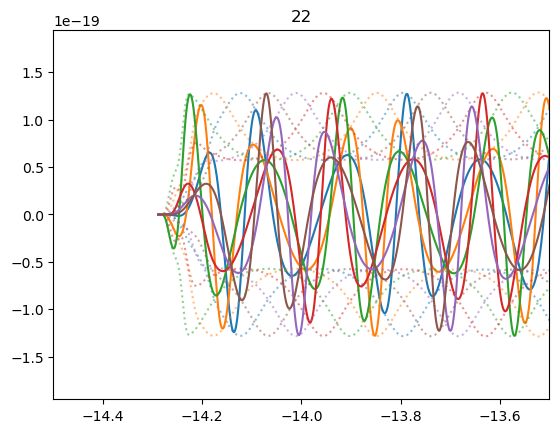

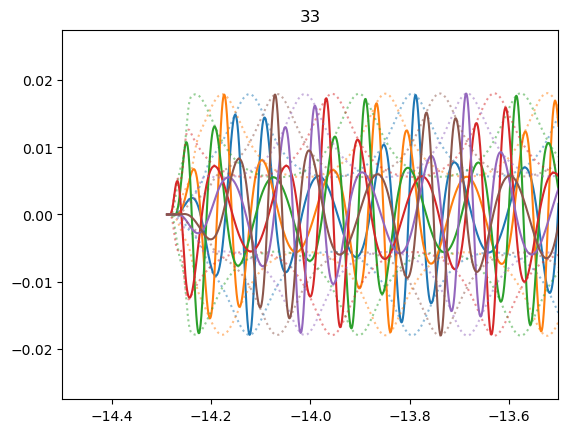

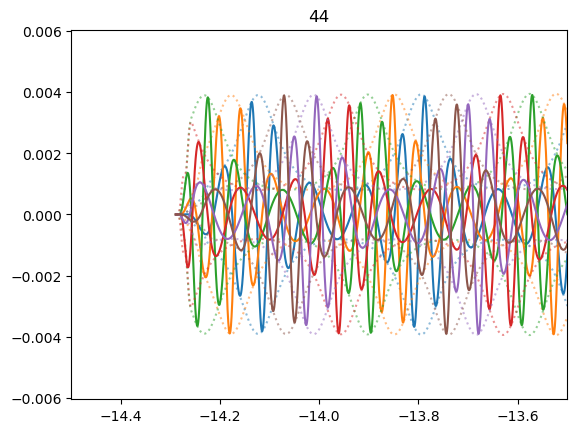

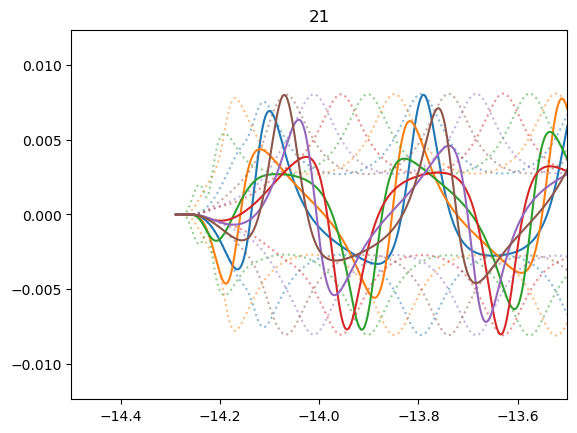

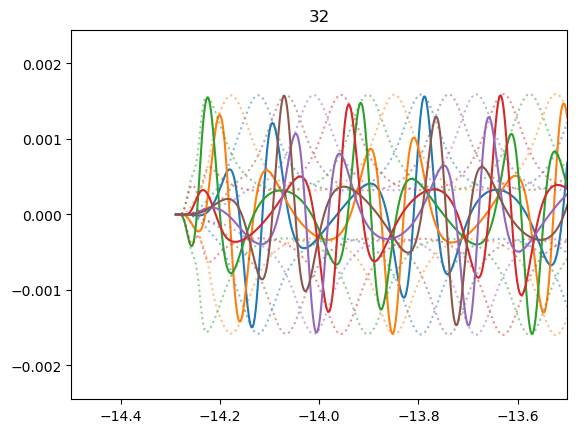

In [66]:
harms = calculate_eccentric_harmonics(
    60, 2, 0.2, 0, 0, 10, 4096, phase=0, inclination=0,
    distance=1, f_ref_e=None, tlen=None, n_ecc_harms=3, n_ecc_gen=6, psd=None,
    orthonormalize=False, align_merger=False, lms=['22', '33', '44', '21', '32'],
    approximant='TEOBResumS-Dali'
)

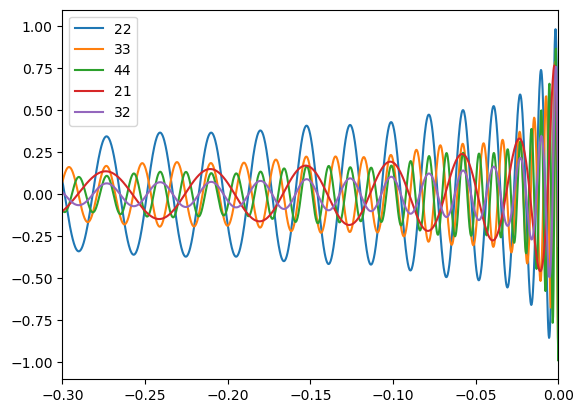

In [72]:
import matplotlib.pyplot as plt
for lm in ['22', '33', '44', '21', '32']:
    try:
        h = harms[lm][0].to_timeseries()
        plt.plot(h.sample_times, h/max(np.abs(h)), label=lm)
        plt.xlim(-0.3, -0)
        plt.legend()
    except:
        pass